<a href="https://colab.research.google.com/github/mansibhakare11/DL_ASS/blob/main/Encoder_DecoderAttetion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Load CSV
df = pd.read_csv('/content/Articles.csv', encoding='ISO-8859-1')
df.dropna(inplace=True)

# Rename columns
df.rename(columns={'Article': 'article', 'Heading': 'headline'}, inplace=True)

# Basic text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['article'] = df['article'].apply(clean_text)
df['headline'] = df['headline'].apply(lambda x: '<start> ' + clean_text(x) + ' <end>')


In [ ]:
# Hyperparameters
vocab_size = 10000
max_len_article = 200
max_len_headline = 20

# Tokenizers
article_tokenizer = Tokenizer(num_words=vocab_size, oov_token='<unk>')
article_tokenizer.fit_on_texts(df['article'])

headline_tokenizer = Tokenizer(num_words=vocab_size, oov_token='<unk>')
headline_tokenizer.fit_on_texts(df['headline'])

# Sequences
article_seq = article_tokenizer.texts_to_sequences(df['article'])
headline_seq = headline_tokenizer.texts_to_sequences(df['headline'])

# Padding
article_seq = pad_sequences(article_seq, maxlen=max_len_article, padding='post')
headline_seq = pad_sequences(headline_seq, maxlen=max_len_headline, padding='post')

# Train-Test Split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    article_seq, headline_seq, test_size=0.1)


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(enc_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

    def call(self, x, hidden, cell):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x, initial_state=[hidden, cell])
        return output, state_h, state_c


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(dec_units)

    def call(self, x, hidden, cell, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state_h, state_c = self.lstm(x, initial_state=[hidden, cell])
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state_h, state_c, attention_weights


In [ ]:
BATCH_SIZE = 64
embedding_dim = 256
units = 512
BUFFER_SIZE = len(input_tensor_train)
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

vocab_inp_size = vocab_size
vocab_tar_size = vocab_size

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    return tf.reduce_mean(loss_ * mask)


In [ ]:
@tf.function
def train_step(inp, targ, hidden, cell):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden, enc_cell = encoder(inp, hidden, cell)
        dec_hidden, dec_cell = enc_hidden, enc_cell
        dec_input = tf.expand_dims([headline_tokenizer.word_index['start']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, dec_cell, _ = decoder(dec_input, dec_hidden, dec_cell, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = loss / int(targ.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

EPOCHS = 10
for epoch in range(EPOCHS):
    enc_hidden, enc_cell = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden, enc_cell)
        total_loss += batch_loss

    print(f'Epoch {epoch+1}, Loss: {total_loss / steps_per_epoch:.4f}')


Epoch 1, Loss: 3.4464
Epoch 2, Loss: 3.1119
Epoch 3, Loss: 3.0274
Epoch 4, Loss: 2.9235
Epoch 5, Loss: 2.8311
Epoch 6, Loss: 2.7576
Epoch 7, Loss: 2.6671
Epoch 8, Loss: 2.5829
Epoch 9, Loss: 2.4887
Epoch 10, Loss: 2.3970


In [ ]:
def evaluate(sentence):
    sentence = clean_text(sentence)
    inputs = article_tokenizer.texts_to_sequences([sentence])[0]
    inputs = pad_sequences([inputs], maxlen=max_len_article, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    hidden, cell = tf.zeros((1, units)), tf.zeros((1, units))
    enc_out, enc_hidden, enc_cell = encoder(inputs, hidden, cell)
    dec_hidden, dec_cell = enc_hidden, enc_cell
    dec_input = tf.expand_dims([headline_tokenizer.word_index['start']], 0)

    for t in range(max_len_headline):
        predictions, dec_hidden, dec_cell, attention_weights = decoder(dec_input, dec_hidden, dec_cell, enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = headline_tokenizer.index_word.get(predicted_id, '')

        if predicted_word == 'end':
            break

        result += predicted_word + ' '
        dec_input = tf.expand_dims([predicted_id], 0)

    return result.strip()


# Test
print(evaluate(df['article'][0]))


pakistan beat pakistan to be among pakistan in world t20


In [ ]:
!pip install rouge-score nltk
import nltk
nltk.download('wordnet')


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1d51b304e4c52e5732af1fd44ca54df037f54b9ea9ad379289eccdde523d2560
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

def compute_metrics(reference, prediction):
    reference_tokens = reference.lower().split()
    prediction_tokens = prediction.lower().split()

    smoothie = SmoothingFunction().method4

    bleu = sentence_bleu([reference_tokens], prediction_tokens, smoothing_function=smoothie)
    meteor = meteor_score([reference_tokens], prediction_tokens)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge = scorer.score(reference, prediction)

    return {
        'BLEU': bleu,
        'METEOR': meteor,
        'ROUGE-1': rouge['rouge1'].fmeasure,
        'ROUGE-2': rouge['rouge2'].fmeasure,
        'ROUGE-L': rouge['rougeL'].fmeasure,
    }


In [ ]:
def evaluate(article):
    article = clean_text(article)
    inputs = [article_tokenizer.word_index.get(w, 1) for w in article.split()]
    inputs = pad_sequences([inputs], maxlen=max_len_article, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    hidden, cell = tf.zeros((1, units)), tf.zeros((1, units))
    enc_out, enc_hidden, enc_cell = encoder(inputs, hidden, cell)
    dec_hidden, dec_cell = enc_hidden, enc_cell
    dec_input = tf.expand_dims([headline_tokenizer.word_index['start']], 0)

    for t in range(max_len_headline):
        predictions, dec_hidden, dec_cell, _ = decoder(dec_input, dec_hidden, dec_cell, enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = headline_tokenizer.index_word.get(predicted_id, '')

        if predicted_word == 'end':
            break

        result += predicted_word + ' '
        dec_input = tf.expand_dims([predicted_id], 0)

    return result.strip()


In [ ]:
num_samples = 200
metrics_list = {'BLEU': [], 'METEOR': [], 'ROUGE-1': [], 'ROUGE-2': [], 'ROUGE-L': []}

for i in range(num_samples):
    article_seq = input_tensor_val[i]
    article_text = ' '.join([article_tokenizer.index_word.get(idx, '') for idx in article_seq if idx > 0])

    reference = df['headline'].values[i]  # use corresponding headline
    prediction = evaluate(article_text)

    metrics = compute_metrics(reference, prediction)

    for metric, value in metrics.items():
        metrics_list[metric].append(value)

# Print average metrics
print("\nAverage Metrics over 100 samples:")
for metric in metrics_list:
    print(f"{metric}: {np.mean(metrics_list[metric]):.4f}")



Average Metrics over 100 samples:
BLEU: 0.0075
METEOR: 0.0262
ROUGE-1: 0.0465
ROUGE-2: 0.0057
ROUGE-L: 0.0431


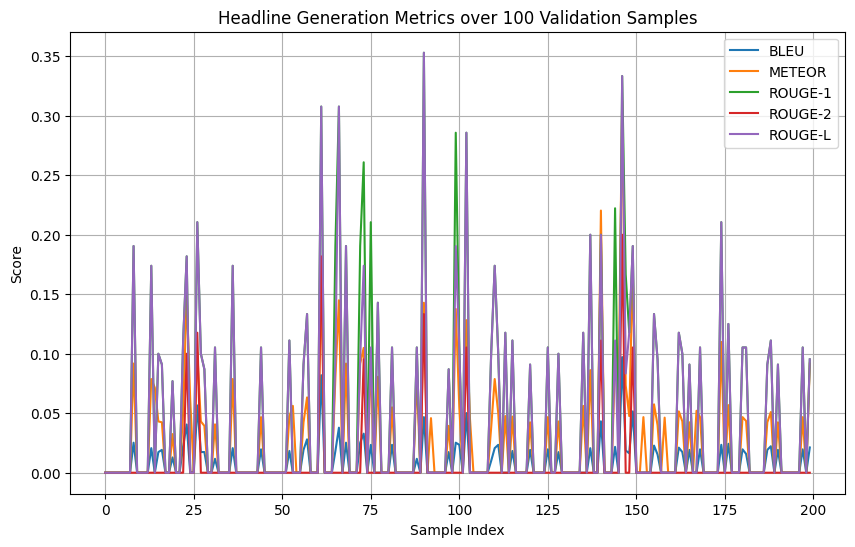

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for metric in metrics_list:
    plt.plot(metrics_list[metric], label=metric)

plt.title("Headline Generation Metrics over 100 Validation Samples")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()
